In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import ot
from utils.image import Image
from utils.Visualizations import *
from utils.utils import *
import itertools
import glob

In [4]:
dotmark_pictures_path = "..\\DOTmark_1.0\\Pictures\\"
full_path = os.path.join(os.getcwd(), dotmark_pictures_path)
resolution = 32
image_numbers = ['01','02','03','04','05','06','07','08','09','10']
noise_values = np.logspace(start = -8, stop = 2, num = 100)
categories_pattern = os.path.join(dotmark_pictures_path, "*")
category_dirs = [path for path in glob.glob(categories_pattern) if os.path.isdir(path)]
category_names = [os.path.basename(category) for category in category_dirs if os.path.isdir(category)]
num_exp = 1000

In [6]:
results_B_x = pd.DataFrame(columns=[
    'Category', 'Image_Pair', 'Alpha_1_Mean', 'Alpha_1_Std', 'Alpha_2_Mean', 'Alpha_2_Std', 
    'B_x_Mean', 'B_x_Std', 'Noise', 'B_x_tilde_Mean', 'B_x_tilde_Std'
    ])

category = "MicroscopyImages"
pair = list(itertools.combinations(image_numbers, 2))[0]  # Choose the first image pair as an example

print(f'Category: {category}, Image_Pair: {pair}')

Category: MicroscopyImages, Image_Pair: ('01', '02')


In [8]:
image1 = Image(resolution, category, pair[0], full_path)
image2 = Image(resolution, category, pair[1], full_path)

for noise in noise_values:
    alpha_1s = np.zeros(num_exp)
    alpha_2s = np.zeros(num_exp)
    B_xs = np.zeros((num_exp, resolution, resolution))  # Store B_x for each experiment
    B_xs_tilde = np.zeros((num_exp, resolution, resolution))  # Store B_x_tilde for each experiment

    for i in range(num_exp):
        results = Image.process_images(image1, image2, noise)
        alpha_1 = (1 / image1.image_post_noised.sum()) - 1
        alpha_2 = (1 / image2.image_post_noised.sum()) - 1
        B_x = image1.image_post_noised * alpha_1 - image2.image_post_noised * alpha_2
        alpha_1s[i] = alpha_1
        alpha_2s[i] = alpha_2
        B_xs[i, :, :] = B_x  # Store each B_x result
        B_xs_tilde[i, :, :] = B_x - alpha_1 * image1.image + alpha_2 * image2.image

    # Calculate the means and standard deviations
    alpha_1_mean, alpha_1_std = alpha_1s.mean(), alpha_1s.std()
    alpha_2_mean, alpha_2_std = alpha_2s.mean(), alpha_2s.std()
    B_x_mean, B_x_std = B_xs.mean(axis=0), B_xs.std(axis=0)
    B_x_tilde_mean, B_x_tilde_std = B_xs_tilde.mean(axis=0), B_xs_tilde.std(axis=0)

    # Store results in the DataFrame
    results_B_x = results_B_x._append({
        'Category': category,
        'Noise': noise,
        'Image_Pair': pair,
        'Alpha_1_Mean': alpha_1_mean,
        'Alpha_1_Std': alpha_1_std,
        'Alpha_2_Mean': alpha_2_mean,
        'Alpha_2_Std': alpha_2_std,
        'B_x_Mean': B_x_mean.mean(),  # Storing the overall mean of the matrix
        'B_x_Std': B_x_std.mean(),  # Storing the overall mean of the std of the matrix
        'B_x_tilde_Mean': B_x_tilde_mean.mean(),
        'B_x_tilde_Std': B_x_tilde_std.mean()
    }, ignore_index=True)

C:\Users\eriki\AppData\Local\Temp\ipykernel_22012\2892555043.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_B_x = results_B_x._append({


In [9]:
results_B_x_new = results_B_x.drop(['Category', 'Image_Pair'], axis=1)
results_B_x_new['log_Noise'] = np.log10(results_B_x['Noise'])
grouped_results = results_B_x_new.groupby('Noise').mean().reset_index()
results_B_x_new.head()

,Alpha_1_Mean,Alpha_1_Std,Alpha_2_Mean,Alpha_2_Std,B_x_Mean,B_x_Std,Noise,B_x_tilde_Mean,B_x_tilde_Std,log_Noise
0,-0.000002,2.977341e-07,-0.000002,3.354693e-07,1.659425e-11,5.184159e-10,1.000000e-08,1.032648e-16,3.445180e-14,-8.00000
1,-0.000003,3.562723e-07,-0.000003,4.178555e-07,2.938078e-11,6.427816e-10,1.261857e-08,2.244312e-16,5.454406e-14,-7.89899
2,-0.000004,4.495662e-07,-0.000004,5.119657e-07,7.608445e-13,7.951086e-10,1.592283e-08,6.441570e-17,8.699640e-14,-7.79798
3,-0.000005,5.486557e-07,-0.000005,6.522752e-07,1.429250e-11,9.901219e-10,2.009233e-08,2.593218e-16,1.381096e-13,-7.69697
4,-0.000006,7.216639e-07,-0.000006,8.233053e-07,-8.003212e-12,1.279076e-09,2.535364e-08,5.633687e-17,2.194273e-13,-7.59596


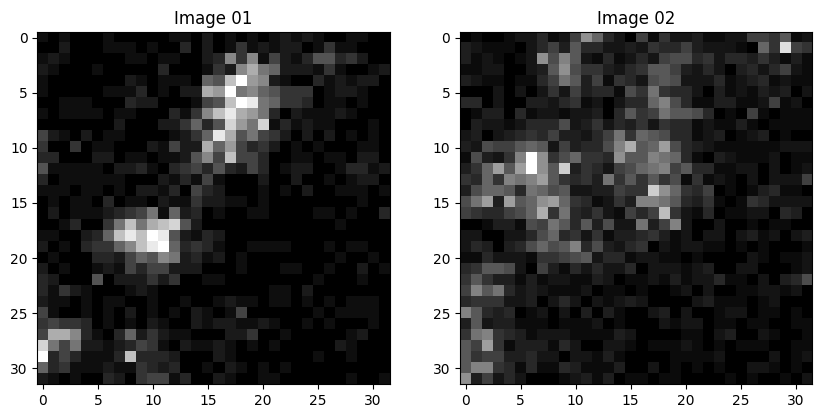

In [10]:
# Show both original images side by side:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image1.image, cmap='gray')
ax[0].set_title(f'Image {pair[0]}')
ax[1].imshow(image2.image, cmap='gray')
ax[1].set_title(f'Image {pair[1]}')
plt.show()

In [11]:
def print_stats(image: np.ndarray):
    print(f'Min: {image[image>0].min()}')
    print(f'Max: {image[image>0].max()}')
    print(f'Mean: {image.mean()}')
    print(f'Num of zeros: {np.count_nonzero(image == 0)}')

In [12]:
type(image1)

utils.image.Image

In [13]:
# Show statistics about the images - mean pixel value, number of zero pixels, etc.
print(f'Image {pair[0]} statistics:')
print_stats(image1.image)
print(f'\nImage {pair[1]} statistics:')
print_stats(image2.image)

Image 01 statistics:
Min: 0.0005389797882579403
Max: 0.009817131857555342
Mean: 0.0009765625
Num of zeros: 429

Image 02 statistics:
Min: 0.00031292671825216206
Max: 0.007254210286754666
Mean: 0.0009765625
Num of zeros: 173


Now, we would like to see that the noise value is capped at about the same time as the minimal value is equal to 

$$min_{pix} = \sigma \sqrt{2log(N^2)}$$

which in our case, where $N=32$, means that:

$$min_{pix} = \sigma \sqrt{2log(1024)}$$

and if we move things around a little we get : 

$$\sigma < \frac{min_{pix}}{\sqrt{2log(1024)}}$$

In [14]:
# Calculate the minimal non-zero pixel value in the images
min_pix_image1 = image1.image[image1.image > 0].min()
min_pix_image2 = image2.image[image2.image > 0].min()

max_sigma_image1 = min_pix_image1 / np.sqrt(2 * (resolution**2))
max_sigma_image2 = min_pix_image2 / np.sqrt(2 * (resolution**2))

print(f'Minimal non-zero pixel value in image {pair[0]}: {min_pix_image1}')
print(f'Maximal sigma value for image {pair[0]}: {max_sigma_image1}')
print(f'\nMinimal non-zero pixel value in image {pair[1]}: {min_pix_image2}')
print(f'Maximal sigma value for image {pair[1]}: {max_sigma_image2}')

Minimal non-zero pixel value in image 01: 0.0005389797882579403
Maximal sigma value for image 01: 1.1909883224989972e-05

Minimal non-zero pixel value in image 02: 0.00031292671825216206
Maximal sigma value for image 02: 6.9147688903298735e-06


In [15]:
max_sigma_image1

1.1909883224989972e-05

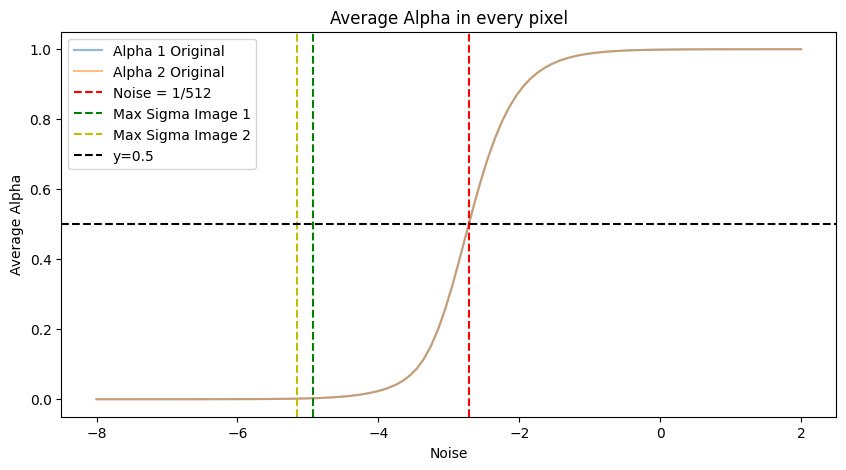

In [16]:
# Plot the alphas:
plt.figure(figsize=(10, 5))
plt.plot(grouped_results['log_Noise'], -grouped_results['Alpha_1_Mean'], label='Alpha 1 Original', alpha=0.5)
plt.plot(grouped_results['log_Noise'], -grouped_results['Alpha_2_Mean'], label='Alpha 2 Original', alpha=0.5)
plt.axvline(x=np.log10(1/512), color='r', linestyle='--', label='Noise = 1/512')
plt.axvline(x=np.log10(max_sigma_image1), color='g', linestyle='--', label='Max Sigma Image 1')
plt.axvline(x=np.log10(max_sigma_image2), color='y', linestyle='--', label='Max Sigma Image 2')
plt.axhline(y=0.5, color='k', linestyle='--', label='y=0.5')
plt.xlabel('Noise')
#plt.yscale('log')
plt.ylabel('Average Alpha')
plt.title('Average Alpha in every pixel')
plt.legend()

plt.show()

Questions about this plot:
* is it symmetric around the point $(0.5, \frac{2}{res^2})$

* What are the max sigma's and how can we interpret them? do the things we want really start happening there?

* How would one change the theoretical proof given that we can divide the pixels into 2 parts.

I would be adressing the third point in the overleaf page.

#### We would like to also look into how the minimal pixel is distributed
and hope that it is usually still big enough to give us some value.

For this, we will explore the minimal non-zero pixel for pure noise, mathematically.
And for the other classes, we would explore it numerically.

In [18]:
df = pd.DataFrame(columns=['Category', 'Image', 'Min_Non_Zero_Pixel', 'Number of Zero Pixels'])

# Find the minimal non-zero pixel value in the images
for category in category_names:
    for image_number in image_numbers:
        image = Image(resolution, category, image_number, full_path)
        print(f'Category: {category}, Image: {image_number}')
        print_stats(image.image)
        # Save the statistics to a dataframe
        df = df._append({
            'Category': category,
            'Image': image_number,
            'Min_Non_Zero_Pixel': image.image[image.image > 0].min(),
            'Number of Zero Pixels': np.count_nonzero(image.image == 0),
        }, ignore_index=True)


Category: CauchyDensity, Image: 01
Min: 4.348960598416978e-05
Max: 0.011089849525963294
Mean: 0.0009765624999999999
Num of zeros: 406
Category: CauchyDensity, Image: 02
Min: 1.97398290530804e-05
Max: 0.005033656408535502
Mean: 0.0009765625
Num of zeros: 107
Category: CauchyDensity, Image: 03
Min: 1.4014238466281742e-05
Max: 0.0035736308089018443
Mean: 0.0009765625
Num of zeros: 16
Category: CauchyDensity, Image: 04
Min: 1.1368028556487734e-05
Max: 0.002898847281904372
Mean: 0.0009765625
Num of zeros: 10
Category: CauchyDensity, Image: 05
Min: 1.0317468505927385e-05
Max: 0.0026309544690114833
Mean: 0.0009765625
Num of zeros: 6
Category: CauchyDensity, Image: 06
Min: 9.590486237652248e-06
Max: 0.0024455739906013236
Mean: 0.0009765625
Num of zeros: 4
Category: CauchyDensity, Image: 07
Min: 9.296617890411468e-06
Max: 0.0023706375620549244
Mean: 0.0009765625
Num of zeros: 2
Category: CauchyDensity, Image: 08
Min: 8.203108978302777e-06
Max: 0.002091792789467208
Mean: 0.0009765625
Num of zero

C:\Users\eriki\AppData\Local\Temp\ipykernel_22012\1225602339.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append({


In [20]:
df['Category'].unique()

array(['CauchyDensity', 'ClassicImages', 'GRFmoderate', 'GRFrough',
       'GRFsmooth', 'LogGRF', 'LogitGRF', 'MicroscopyImages', 'Shapes',
       'WhiteNoise'], dtype=object)

In [22]:
df.head()

,Category,Image,Min_Non_Zero_Pixel,Number of Zero Pixels
0,CauchyDensity,01,0.000043,406
1,CauchyDensity,02,0.000020,107
2,CauchyDensity,03,0.000014,16
3,CauchyDensity,04,0.000011,10
4,CauchyDensity,05,0.000010,6


In [23]:
# Calculate the mean minimal pixel for each category, remove image number column too
df_new = df.drop('Image', axis=1)
df_new = df_new.groupby('Category').mean().reset_index()

In [24]:
df_new

,Category,Min_Non_Zero_Pixel,Number of Zero Pixels
0,CauchyDensity,0.000014,55.5
1,ClassicImages,0.000194,0.0
2,GRFmoderate,0.000084,1.1
3,GRFrough,0.000059,1.1
4,GRFsmooth,0.000015,1.5
5,LogGRF,0.000038,8.3
6,LogitGRF,0.000008,8.8
7,MicroscopyImages,0.000373,225.6
8,Shapes,0.001918,462.8
9,WhiteNoise,0.000009,5.1


I'm not sure about what we can deduct from here. some of the classes seem to be very low while others are higher. The highest class is shapes(as we would expect)